In [ ]:
"""
Ensemble methods (with notes below!):

1. Voting Classifier (Hard, Soft)
2. Bagging Classifier
3. Boosting (AdaBoost, Gradient Boost)
4. Stacking


Learners:

1. Logistic Regression
2. kNN
3. Naive Bayes
4. Decition Tree
5. Random Forests
6. Extra Trees
7. AdaBoost
8. Gradient Boost



"""

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, StackingClassifier)

In [51]:
# Load data
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')


X_train = pd.read_pickle('../dump/X_adasyn')
y_train = pd.read_pickle('../dump/y_adasyn')
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

## Prepare models

In [15]:
# Define models (default)
lr_model = LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
nb_model = GaussianNB()
knn_model = KNeighborsClassifier(n_neighbors=5)
# svc_model = SVC(probability=True, gamma="scale")
rf_model = RandomForestClassifier(max_depth=4, max_features=sqrt, min_samples_leaf=0.1, n_estimators=300)
et_model = ExtraTreesClassifier(n_estimators=100)
ada_model = AdaBoostClassifier()

# Notice that these model names (strings) match the models themselves (variables, above)
# models = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]
models = ["lr_model", "nb_model", "knn_model","rf_model", "et_model", "ada_model"]

In [132]:
# Define models (refined)
lr_model = LogisticRegression()
nb_model = GaussianNB()
knn_model = KNeighborsClassifier()
svc_model = SVC(probability=True, gamma="scale")
rf_model = RandomForestClassifier(n_estimators=100)
et_model = ExtraTreesClassifier(n_estimators=100)
ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=2500,algorithm="SAMME.R",learning_rate=0.001)

# Notice that these model names (strings) match the models themselves (variables, above)
# models = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]
models2 = ["lr_model", "nb_model", "knn_model","rf_model", "et_model", "ada_model"]

In [133]:
import os

if not os.path.exists('models2'):
    os.makedirs('models2')

In [134]:
for model_name in models:
    curr_model = eval(model_name)  # The string refers us to the variable
    
    curr_model.fit(X_train, y_train)
    
    # Notice the syntax here.
    with open(f"models2/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [135]:
# Load pre-trained/tuned models

# model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]
model_names = ["lr_model", "nb_model", "knn_model","rf_model", "et_model", "ada_model"]

for model_name in model_names:
    with open(f"models2/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")
        

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [19]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} ROC AUC score: {roc_auc_score(y_test,curr_model.predict_proba(X_test)[:, 1])}')

lr_model ROC AUC score: 0.7653097499463404
nb_model ROC AUC score: 0.6866291496744652
knn_model ROC AUC score: 0.6898381045646419
rf_model ROC AUC score: 0.7492023726479216
et_model ROC AUC score: 0.7383692852543464
ada_model ROC AUC score: 0.733859644415826


In [136]:
# From models2
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} ROC AUC score: {roc_auc_score(y_test,curr_model.predict_proba(X_test)[:, 1])}')

lr_model ROC AUC score: 0.7644098340130213
nb_model ROC AUC score: 0.6842032893324748
knn_model ROC AUC score: 0.6929464477355656
rf_model ROC AUC score: 0.7528467527008658
et_model ROC AUC score: 0.7412931736066396
ada_model ROC AUC score: 0.7816815124847964


## 1. Voting Classifier

Use a diverse set of classifiers by using different training algorithms but the same train data.

### Majority vote (hard)

In [20]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', # <-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)
pred = voting_classifer.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Majority vote):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7341474870831376 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.87      0.75      0.81      1553
           1       0.51      0.68      0.58       576

    accuracy                           0.73      2129
   macro avg       0.69      0.72      0.69      2129
weighted avg       0.77      0.73      0.74      2129



### Average vote (soft)

In [21]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', # <-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)
pred = voting_classifer.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Average vote):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7111319868482856 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.87      0.71      0.78      1553
           1       0.48      0.72      0.57       576

    accuracy                           0.71      2129
   macro avg       0.67      0.71      0.68      2129
weighted avg       0.76      0.71      0.73      2129



### Weighted vote (soft)

In [41]:
# create voting classifier
weights = [1.1,2.2,3.3,3.3,2.2,1.1]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Weighted vote):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7186472522310944 

Classification report (Weighted vote):

               precision    recall  f1-score   support

           0       0.87      0.72      0.79      1553
           1       0.49      0.71      0.58       576

    accuracy                           0.72      2129
   macro avg       0.68      0.72      0.68      2129
weighted avg       0.77      0.72      0.73      2129



#### Visualization of weighted votes

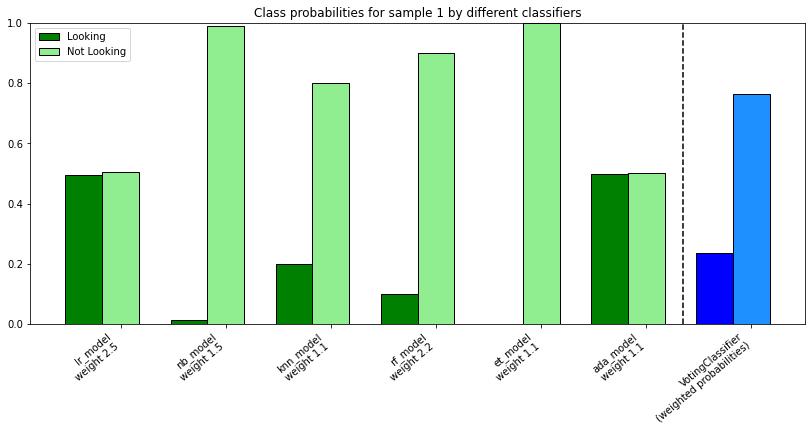

In [31]:
# predict class probabilities for all classifiers
probas = [c.predict_proba(X_train) for n,c in model_list]
probas += [voting_model.predict_proba(X_train)]
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
# plotting

N = 7  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-7
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), 
            width,
            color='green', 
            edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), 
            width,
            color='lightgreen', 
            edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0,0,0,0,0,0, class1_1[-1]], 
            width,
            color='blue', 
            edgecolor='k')
p4 = ax.bar(ind + width, [0,0,0,0,0,0, class2_1[-1]], 
            width,
            color='dodgerblue', 
            edgecolor='k')

# plot annotations
plt.axvline(N - 1.3, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
x_labels = [f"{n}\nweight {weights[i]}" for i, n in enumerate(model_names)]
ax.set_xticklabels(
    x_labels + ['VotingClassifier\n(weighted probabilities)'],
    rotation=40,
    ha='right')

plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['Looking', 'Not Looking'], loc='upper left')
plt.tight_layout()
plt.gcf().set_size_inches(12, 8)
plt.show()

## 2. Bagging Classifier

Use the same training algorithm for every predictor, but train them on different random subsets of the training data. Bagging is short for *bootstrap aggregating*.

* Bagging: sampling is performed with replacement
* Pasting: sampling is performed without replacememt

Generally, the ensemble has a similar bias but a lower variance than a single predictor trained on the original training data. Note that bootstrapping introduces a bit more diversity in the subsets, so **bagging** ends up with a slightly **higher bias** than pasting. But this also means that the predictors end up being **less correlated** (so the ensemble's **variance is reduced**).

### A. Random Forest

`RandomForestClassifier`

Random Forest is an ensemble of Decision Trees, trained via bagging method. RF introduces extra randomness when growing trees; instead of searching for the very best feature when splitting s node, it searches for the best feature among a random subset of features.

**Greater tree diversity --> higher bias lower variance --> overall a better model**

This BaggingClassifier is roughly equivalent to the RandomForestClassifier:
```
BaggingClassifier(
                  DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
                  n_estimators=500, max_samples=1.0, bootstrrap=True, n_jobs=-1)
                  
                  
RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
```

Note that `n_jobs` tells Scikit-Learn the number of CPU cores to use for training and predictions; `-1` means to use all available cores.



### B. Extra-Trees

`ExtraTreeClassifier`

Compared to Random Forest, you can make the trees even more random by using random thresholds for each feature rather than searching for the best possible thresholds. This makes Extra-trees much faster to train! Extra-Trees is short for *Extremely Randomized Trees*.

In [70]:
et = ExtraTreesClassifier(n_estimators=100)
et.fit(X_train,y_train)
pred = et.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Extra-Trees):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7374354156881164 

Classification report (Extra-Trees):

               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1553
           1       0.51      0.52      0.52       576

    accuracy                           0.74      2129
   macro avg       0.67      0.67      0.67      2129
weighted avg       0.74      0.74      0.74      2129



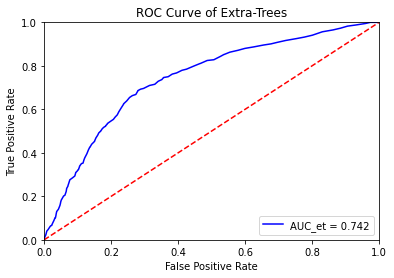

In [71]:
# Extra-Tree ROC
y_scores = et.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_et = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Extra-Trees')
plt.show()

### C. Test on Bagging Logistic Regression

In [68]:
# Test using Logistic Regression model as base learner forr bagging methods

bag = BaggingClassifier(
        LogisticRegression(solver='lbfgs', C=10000, penalty='l2'),
        n_estimators = 1000, max_samples = 500, bootstrap=True, n_jobs = -1, oob_score=True)
bag.fit(X_train,y_train)
pred = bag.predict(X_test)
print('Out-of-bag evaluation:',bag.oob_score_,'\n')
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Bagging Logistic Regression):\n\n',classification_report(y_test,pred))

Out-of-bag evaluation: 0.6859134415314191 

Accuracy score: 0.7177078440582433 

Classification report (Weighted vote):

               precision    recall  f1-score   support

           0       0.88      0.71      0.79      1553
           1       0.49      0.74      0.59       576

    accuracy                           0.72      2129
   macro avg       0.68      0.72      0.69      2129
weighted avg       0.77      0.72      0.73      2129



In [69]:
# Actually quite similar to the results of grid search cv

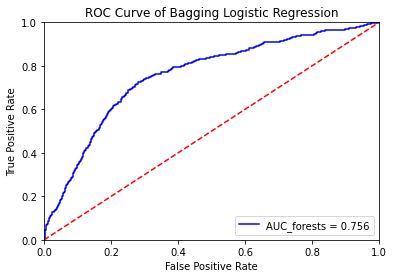

In [61]:
# Bagging Logistic Regression ROC
y_scores = bag.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Bagging Logistic Regression')
plt.show()

## 3. Boosting Classifier

Combine several weak learners into a strong learner. Most boosting methods train predictors sequentially, each trying to correct its predecessor. There are many boosting methods. Here only ___ most popular ones are tested out.

### A. AdaBoost

Short for *Adaptive Boosting*. Pays more attention to the training instances that the predecessor **underfitted**. (Relative weight of misclassified training instances is increased). Once all predictors are trained, the ensemble makes predictions like bagging, except that the predictors have very different weights depending on their overrall accuracy on the weighted training set. Drawback: cannot be parrallelized; does not scale as well as bagging.

Algorithm:

1. Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$
2. The first predictor is trained and its weighted error rate $r_1$ is computed on the training set:

    $r_j = \frac{\displaystyle\sum^m_{i=1, \hat{y}_j^{(i)}\neq y^{(i)}} w^{(i)}}{\displaystyle\sum_{i=1}^m w^{(i)}}$,
    where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.
    
3. The predictor's weight $\alpha_j$ is then computed using (**the more accurate the predictor is, the higher its weight will be**):

    $\alpha_j = \eta$ $log \frac{1-r_j}{r_j}$, where $\eta$ is the learning rate (hyperparameter, deaults to 1). 
    
    
4. Nex the instance weights are updated (**the misclassified instances are boosted**):

    $w^{(i)}$               if $\hat{y}_j^{(i)} = y^{(i)}$
    
    ${w^{(i)}e^{\alpha_j}}$ if $\hat{y}_j^{(i)} \neq y^{(i)}$
    
    
   (All the instance weights are normalized: diveded by $\displaystyle \sum_{i=1}^m w^{(i)}$).
   
   
5. Finally, a new predictor is trained using the updated weights, and the whole process is repeated. The algorithm stops when the desired number of predictors is reacehd, or when a perfect predictor is found.

6. To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

In [102]:
ada = AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1),
                        n_estimators=2500,algorithm="SAMME.R",learning_rate=0.001)
ada.fit(X_train,y_train)
pred = ada.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Extra-Trees):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7261625176139033 

Classification report (Extra-Trees):

               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1553
           1       0.50      0.74      0.59       576

    accuracy                           0.73      2129
   macro avg       0.69      0.73      0.69      2129
weighted avg       0.78      0.73      0.74      2129



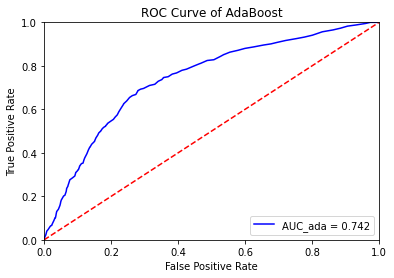

In [75]:
# AdaBoost ROC
y_scores = et.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_ada = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of AdaBoost')
plt.show()

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

ada_2 = AdaBoostClassifier()
n_estimators = [50,500,1000]
learning_rate = [0.02,0.05,0.1]

In [83]:
ada_2.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
# Define grid search
grid = dict(n_estimators = n_estimators, learning_rate = learning_rate)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=ada_2, param_grid=grid, n_jobs=-1, cv=5, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

### B. Gradient Boost

Similar to AdaBoost, but instead of tweaking the instance weights at every iteration, Gradient Boost tries to fit the new predictor to the *residual errors* made by the previous predictor.

Note that the `learning_rate` hyperparameter scales the contribution of each tree. If it's set to be low, more trees in the ensemble are needed to fit the training set. But the predictions will usually generalize betterr. This is a regularization technique called **shrinkage**.


Find optimal number of trees: early stopping; use the `stage_predict()` method. At each stage of training, it returns an iterator over the predictions made by the ensemble.

In [103]:
gbrt = GradientBoostingClassifier()
gbrt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [104]:
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train,y_train)
pred = gbrt.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Extra-Trees):\n\n',classification_report(y_test,pred))

Accuracy score: 0.443400657585721 

Classification report (Extra-Trees):

               precision    recall  f1-score   support

           0       0.90      0.27      0.41      1553
           1       0.32      0.92      0.47       576

    accuracy                           0.44      2129
   macro avg       0.61      0.59      0.44      2129
weighted avg       0.74      0.44      0.43      2129



In [127]:
gbrt_2 = GradientBoostingClassifier(n_estimators=500,learning_rate=0.8,subsample=1)
gbrt_2.fit(X_train,y_train)
pred = gbrt_2.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Extra-Trees):\n\n',classification_report(y_test,pred))

Accuracy score: 0.28276186002818227 

Classification report (Extra-Trees):

               precision    recall  f1-score   support

           0       0.93      0.02      0.04      1553
           1       0.27      1.00      0.43       576

    accuracy                           0.28      2129
   macro avg       0.60      0.51      0.23      2129
weighted avg       0.75      0.28      0.14      2129



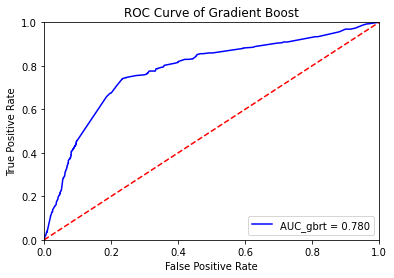

In [116]:
# AdaBoost ROC
y_scores = gbrt_2.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_gbrt = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Gradient Boost')
plt.show()

### C. XGBoost

## 4. Stacked Classifier

Instead of using trivial functions such as hard voting to aggregate the predictions of all predictors in an ensemble, this method trains a model to *perform* the aggregation. The final predictor is called a *blender*, or a *meta-learner*.

To train the blender, a common approach is to use a hold-out set. The training set is split into two subsets.

1. The first subset is used to train the predictors in the first layer.
2. Next, the first layer predictors (there are $n$ of them) are used to make predictions on the second (hold-out) set.
3. Each instance in the hold-out set now has $n$ predicted values.
4. Create a new training set using the predicted values as features.
5. The blender is trained on this new training set and learns to predict the target values given the first layer's predictions.


Note that it is possible to train several different blenders.

In [42]:
stacked = StackingClassifier(
    estimators=model_list, 
    final_estimator=BernoulliNB())

stacked.fit(X_train, y_train)
pred = stacked.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Weighted vote):\n\n',classification_report(y_test,pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy score: 0.5246594645373415 

Classification report (Weighted vote):

               precision    recall  f1-score   support

           0       0.88      0.40      0.55      1553
           1       0.35      0.86      0.49       576

    accuracy                           0.52      2129
   macro avg       0.61      0.63      0.52      2129
weighted avg       0.74      0.52      0.54      2129



In [128]:
stacked = StackingClassifier(
    estimators=model_list, 
    final_estimator=LogisticRegression())

stacked.fit(X_train, y_train)
pred = stacked.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Stacking):\n\n',classification_report(y_test,pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy score: 0.7322686707374354 

Classification report (Weighted vote):

               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1553
           1       0.50      0.61      0.55       576

    accuracy                           0.73      2129
   macro avg       0.67      0.69      0.68      2129
weighted avg       0.75      0.73      0.74      2129



In [138]:
# From models2
stacked = StackingClassifier(
    estimators=model_list, 
    final_estimator=LogisticRegression())

stacked.fit(X_train, y_train)
pred = stacked.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Stacking):\n\n',classification_report(y_test,pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy score: 0.7280413339596055 

Classification report (Stacking):

               precision    recall  f1-score   support

           0       0.85      0.76      0.80      1553
           1       0.50      0.63      0.56       576

    accuracy                           0.73      2129
   macro avg       0.67      0.70      0.68      2129
weighted avg       0.75      0.73      0.74      2129

